In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

sns.set(style="ticks")
plt.style.use("fivethirtyeight")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor #Random Forest Regressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
train = pd.read_csv('train.csv')

In [4]:
print(f'Number of rows {train.shape[0]} and Number of columns: {train.shape[1]}') 

Number of rows 891 and Number of columns: 12


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Exploring and Understanding the Data

## Questions regarding the data

1.) Who were the passengers on the Titanic?

2.) What deck were the passengers on and how does that relate to their class?

3.) Where did the passengers come from?

4.) Who was alone and who was with family?

5). What factors helped someone survive the sinking?

#### 1.) Who were the passenger on the Titanic?

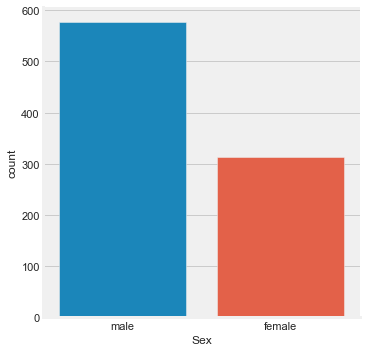

In [7]:
# Gender
sns.catplot('Sex', data=train, kind='count')

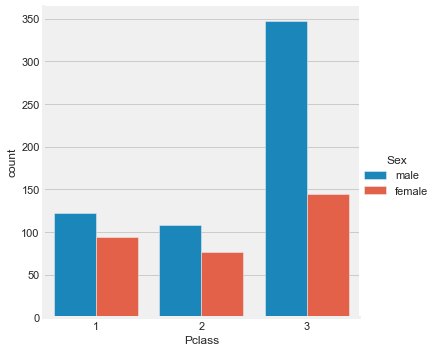

In [8]:
#Pclass
sns.catplot('Pclass',data=train,hue='Sex',kind='count')

There is clearly more males than females in the 3rd class.

Cosider children on the ship.

In [9]:
# Create a new colummn: "Person" in which every person under 16 is a child

train['Person'] = train.Sex
train.loc[train['Age'] < 16, 'Person'] = 'child'

In [10]:
train.Person.value_counts()

male      537
female    271
child      83
Name: Person, dtype: int64

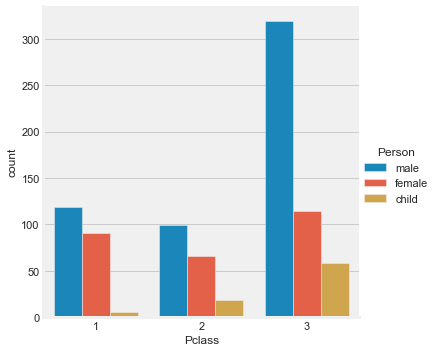

In [11]:
sns.catplot('Pclass',data=train,hue='Person',kind='count')

Comparitivly, there is a lot children in the 3rd class but not many in the 1st class. 

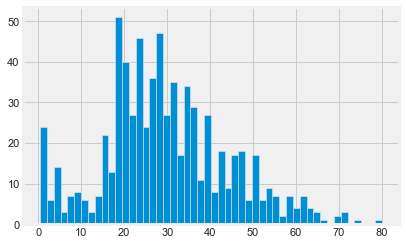

In [12]:
train.Age.hist(bins=50)

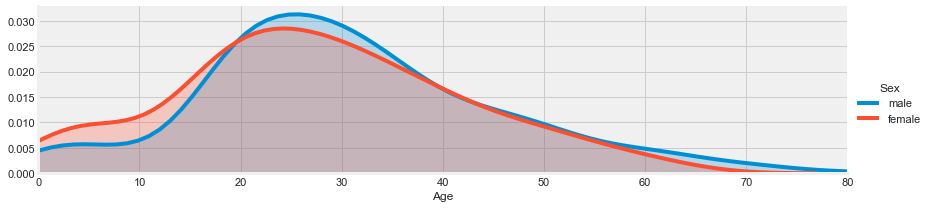

In [13]:
fig = sns.FacetGrid(train,hue='Sex',aspect=4)
fig.map(sns.kdeplot, 'Age', shade=True)
fig.set(xlim=(0,train.Age.max()))
fig.add_legend()

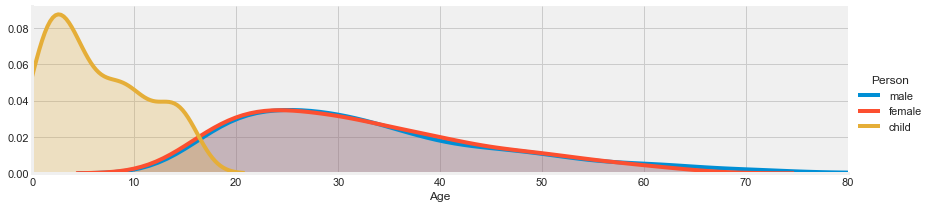

In [14]:
#now check where hue is equal to person
fig = sns.FacetGrid(train, hue='Person',aspect=4)
fig.map(sns.kdeplot, 'Age', shade=True)
fig.set(xlim=(0,train.Age.max()))
fig.add_legend()

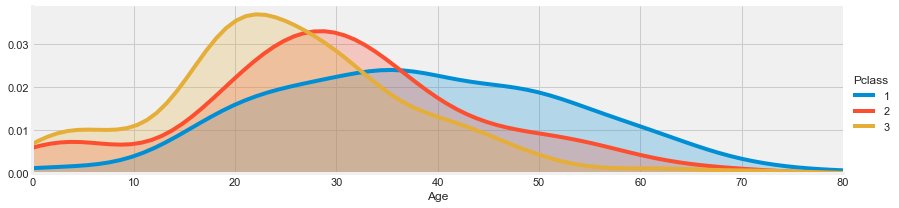

In [15]:
#change the hue to pclass
fig = sns.FacetGrid(train, hue='Pclass', aspect = 4)
fig.map(sns.kdeplot, 'Age', shade=True)
fig.set(xlim=(0,train.Age.max()))
fig.add_legend()

#### 2. What deck were the passengers on and how does that relate to their class?

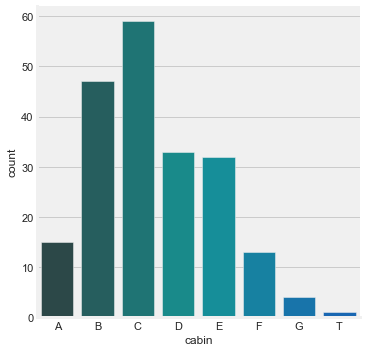

In [16]:
deck = train.Cabin.dropna()
levels = deck.str.extract('([a-zA-Z ])', expand=False)

cabin_df = pd.DataFrame()
cabin_df['cabin'] = levels
cabin_df.sort_values(by='cabin',inplace=True)
sns.catplot('cabin',data=cabin_df,kind='count', palette='winter_d')

#### 3. Where did the passengers come from?

In [17]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

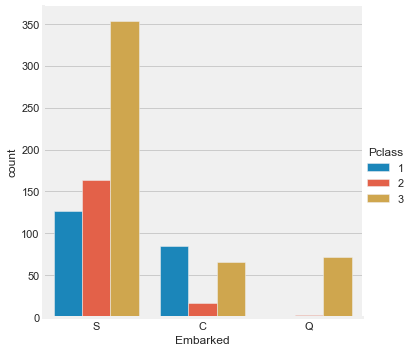

In [18]:
sns.catplot('Embarked', data=train, hue='Pclass', kind='count',order=['S', 'C', 'Q'])

Everyone from Queenstown are almost 3rd class passengers. This could be a potenital error. Another possibility is that the town is really poor. It would be intresting to look at the economics of the town. 

#### 4. Who was alone and who was with their family?

In [19]:
train['alone'] = train.SibSp + train.Parch
train.loc[train.alone > 0, 'alone'] = 'with family'
train.loc[train.alone == 0, 'alone'] = 'alone'

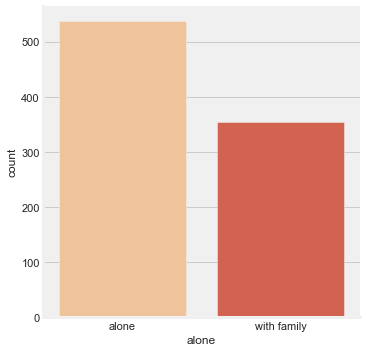

In [20]:
sns.catplot('alone',data=train, kind='count', palette='OrRd', order=['alone','with family'])

#### 5. What factors helped someone survive the sinking?

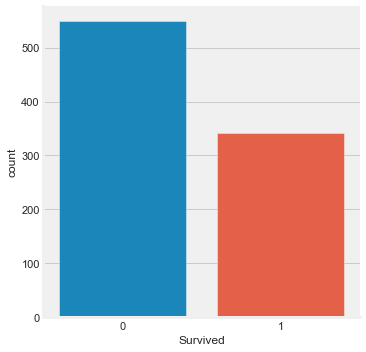

In [21]:
sns.catplot('Survived', data=train, kind='count')

Compared to those who survived, many more died. Next we check how class had an impact on survival rate.

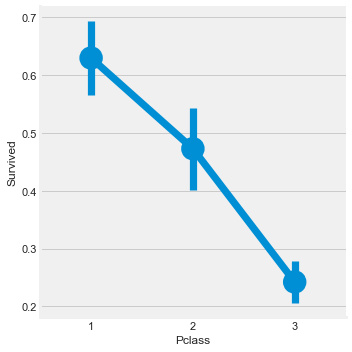

In [22]:
sns.catplot('Pclass', 'Survived', data=train, kind='point')

The survival rate for the 3rd class is substantially lower. This could be due to the fact that there is clearly a larger amount of men compared to women in the 3rd class. 

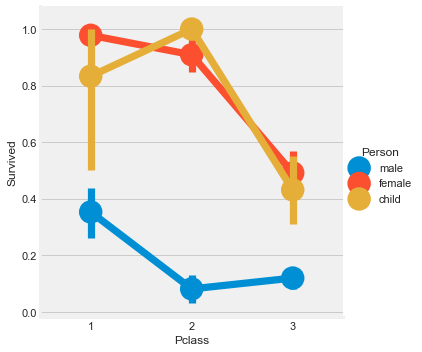

In [23]:
sns.catplot('Pclass', 'Survived', data=train, hue='Person', kind='point')

Being male or being in the 3rd class are not favourable for suvival. 

In [24]:
# checking if age affects survival rate

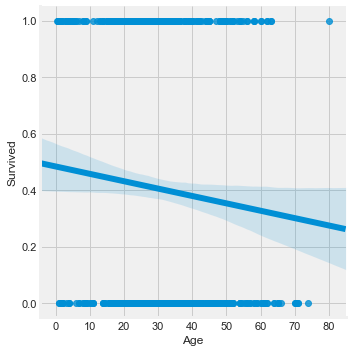

In [25]:
sns.lmplot('Age', 'Survived',data=train)

There is general trend that the older the passenger was, the less likely they survived. 

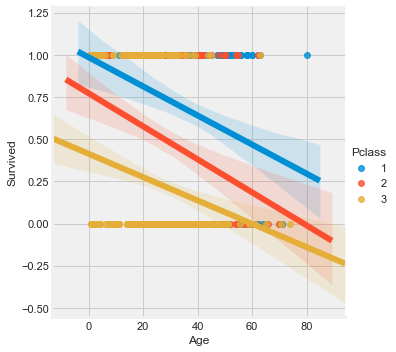

In [26]:
sns.lmplot('Age', 'Survived', hue='Pclass', data=train)

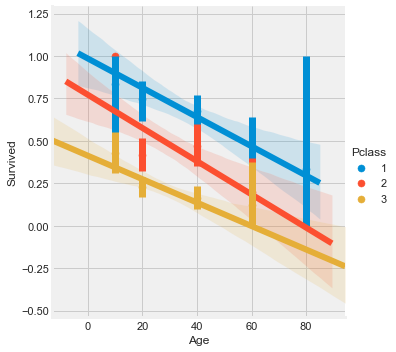

In [27]:
generations = [10,20,40,60,80]
sns.lmplot('Age','Survived',hue='Pclass', data=train, x_bins = generations)

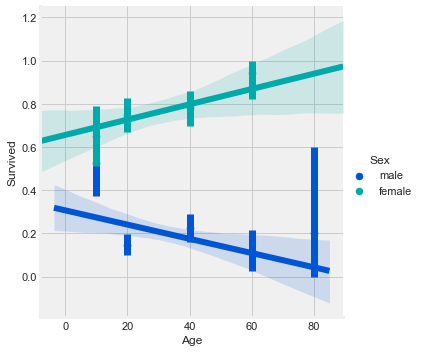

In [28]:
sns.lmplot('Age', 'Survived', hue='Sex',data=train, palette='winter',x_bins=generations)

Intresting how female's survival rate goes up as their age increases while male's survival rate goes down while their age increases.

## Cleaning with Data

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [30]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    final_df = pd.concat([total, percentage],axis=1, keys=['Total', 'Percentage'])
    final_df = final_df[final_df.Total != 0]
    return final_df

In [31]:
missing_percentage(train)

,Total,Percentage
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


In [32]:
missing_percentage(test)

,Total,Percentage
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24


In [33]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


By looking at the rows, three similarities pop out. Once being that they paid the same amoung for the ticket. Another being that they are from the same pclass. Finally they have the same cabin. This suggests that have embarked from the same place.

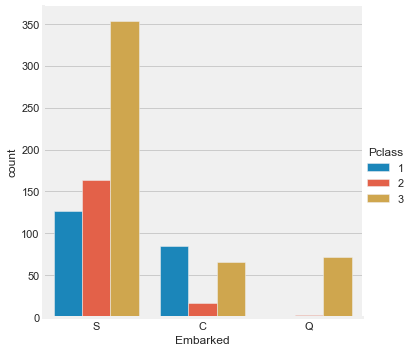

In [34]:
sns.catplot('Embarked', data=train, hue='Pclass', kind='count')

In [35]:
train.Embarked.fillna('C', inplace=True)

In [36]:
# Cabin 

In [37]:
print(f'Train Data: Cabin Missing   {train.Cabin.isnull().sum()/len(train.Cabin)}')
print(f'Test Data: Cabin Missing    {test.Cabin.isnull().sum()/len(test.Cabin)}')

Train Data: Cabin Missing   0.7710437710437711
Test Data: Cabin Missing    0.7822966507177034


In [38]:
# we have two options
    # 1. Remove the entire feature
    # 2. Try to think of a good way to use it

In [39]:
# Before that, we combine the train and test

In [40]:
index_of_train = train.index
index_of_test = test.index

In [41]:
survived_df = train.Survived
train = train.drop(['Survived'], axis=1)
all_data = pd.concat([train, test],ignore_index=False)
all_data.Cabin.fillna('N', inplace=True)

In [42]:
all_data.Cabin = all_data.Cabin.str[0]

In [43]:
all_data.Cabin.value_counts()

N    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [44]:
all_data.groupby('Cabin')['Fare'].mean().sort_values()

Cabin
G     14.205000
F     18.079367
N     19.132707
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: Fare, dtype: float64

In [45]:
def cabin_estimator(i):
    """Grouping cabin feature by the first letter"""
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

In [46]:
all_data['Cabin'] = all_data.apply(lambda x: cabin_estimator(x.Fare) if x.Cabin == 'N' else x.Cabin,axis=1)

In [47]:
all_data.Sex = all_data.Sex.map({'male':1, 'female':0})

In [48]:
all_data['Family'] = all_data.SibSp + all_data.Parch

In [49]:
all_data['Title'] = all_data.Name.str.extract('([A-Za-z]+)\.')
all_data['Title'] = all_data['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Miss'])

In [50]:
all_data['is_alone'] = all_data.Family.map(lambda x: 1 if x == 0 else 0)

In [51]:
train = all_data[:index_of_train.stop]
train['Survived'] = survived_df
test = all_data[index_of_train.stop:]

In [52]:
# Dealing with Fare null values

In [53]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Title,is_alone
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,B,S,0,Mr,1


In [54]:
missing_value_for_fare = all_data[(all_data.Pclass == 3) & 
                     (all_data.Embarked == "S") & 
                     (all_data.Sex == "male")].Fare.mean()
test.Fare.fillna(missing_value_for_fare, inplace=True)

In [55]:
# Age

Age is one of the most important feature according to our investigation. We are missing approx 20% of the data. We can't replace with mean or median. We will use Random Forest Regressor to impute missing values instead of Null values. 

In [56]:
# More Insight
train.groupby('Sex').mean()['Survived']

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

In [57]:
train.groupby('Pclass').mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [58]:
train.Survived.sum() / len(train.Survived)

0.3838383838383838

From the insighnts:

1. The train data set has 891 raw and 9 columns
2. Only 38% percentage of passengers survived the journey
3. 74% of the female passengers surves where as only 19% male passengers survived
4. 63% first class survived while 24% lower class survived


In [59]:
(train.corr()**2).Survived.sort_values(ascending=False)

Survived       1.000000
Sex            0.295231
Pclass         0.114569
Fare           0.066207
is_alone       0.041358
Parch          0.006663
Age            0.005963
SibSp          0.001248
Family         0.000277
PassengerId    0.000025
Name: Survived, dtype: float64

In [60]:
train['name_length'] = train.Name.map(len)
test['name_length'] = test.Name.map(len)

In [61]:
def name_length_group(size):
    a = ''
    if (size <=20):
        a = 'short'
    elif (size <=35):
        a = 'medium'
    elif (size <=45):
        a = 'good'
    else:
        a = 'long'
    return a

In [62]:
train['name_length_group'] = train['name_length'].map(name_length_group)
test['name_length_group'] = test['name_length'].map(name_length_group)

In [63]:
def family_group(size):
    a = ''
    if size == 0:
        a = 'loner'
    elif size <= 4:
        a = 'small'
    else:
        a = 'large'
    return a

In [64]:
train.family_group = train.Family.apply(family_group)
test.family_group = test.Family.apply(family_group)

In [65]:
# drop Ticket as I couldn't identify any logic
train.drop(['Ticket'],axis = 1, inplace=True)
test.drop(['Ticket'],axis = 1, inplace=True)

In [66]:
test.groupby('Pclass').mean()['Fare']

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [67]:
test.Fare = test.Fare.fillna(12.459678)

In [68]:
# Fare is a record of the total fare rather than the fare of indivudal passenger
train['calculated_fare'] = train.Fare/((train.Family) + 1)
test['calculated_fare'] = test.Fare/((test.Family) + 1)

In [69]:
def fare_group(fare):
    """
    This function creates a fare group based on the fare provided
    """
    
    a= ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = "very_high"
    return a

train['fare_group'] = train['calculated_fare'].map(fare_group)
test['fare_group'] = test['calculated_fare'].map(fare_group)

In [70]:
train.drop(['PassengerId','Name'], axis=1, inplace=True)

test.drop(['PassengerId','Name'], axis=1, inplace=True)

In [71]:
train = pd.get_dummies(train, columns = ['Title', 'Pclass', 'Cabin', 'Embarked', 'name_length_group', 'fare_group'], drop_first=False)
test = pd.get_dummies(test, columns = ['Title', 'Pclass', 'Cabin', 'Embarked', 'name_length_group', 'fare_group'], drop_first=False)

In [72]:
train = train.drop(['Family', 'Fare', 'name_length'], axis = 1)
test = test.drop(['Family', 'Fare', 'name_length'], axis = 1)

#### Dealing with missing value: age

In [73]:
# function fills the dataframe regarding age with missing values

In [74]:
df = train

In [75]:
def completing_age(df):
    df = df.drop(['Survived'], axis=1) if 'Survived' in df.columns else df
    temp_train = df[~df.Age.isnull()]
    temp_test = df.loc[df.Age.isnull()]
    y = temp_train.Age.values
    x = temp_train.drop(['Age'], axis=1).values
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x,y)
    predicted_age = rfr.predict(temp_test.drop(['Age'],axis=1))
    df.loc[df.Age.isnull(), 'Age'] = predicted_age
    return df

In [76]:
train = completing_age(train)
test = completing_age(test)

In [77]:
def age_group_fun(age):
    a=''
    if age <= 1:
        a = 'infant'
    elif age <= 4:
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a

In [78]:
train['age_group'] = train['Age'].map(age_group_fun)
test['age_group']  = test['Age'].map(age_group_fun)

In [79]:
train = pd.get_dummies(train, columns=['age_group'], drop_first=True)
test = pd.get_dummies(test, columns=['age_group'], drop_first=True)

In [80]:
X = train
y = survived_df

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=0)

## Feature Scaling

In [82]:
std_scale = StandardScaler()

In [83]:
X_train = std_scale.fit_transform(X_train)
X_test = std_scale.fit_transform(X_test)

In [84]:
pd.DataFrame(X_train, columns=train.columns).sample(6)

,Sex,Age,SibSp,Parch,is_alone,calculated_fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,fare_group_mid,fare_group_very_high,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_old,age_group_senior_citizen,age_group_teenager,age_group_toddler
269,0.724083,0.062213,-0.455235,-0.469509,0.803996,-0.333271,-0.226156,-0.502096,0.812507,-0.407849,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,-0.292592,-0.09198,-0.204837,-0.285779,-0.191107
253,0.724083,-0.275408,0.403373,-0.469509,-1.243788,-0.296643,-0.226156,-0.502096,0.812507,-0.407849,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,-0.292592,-0.09198,-0.204837,-0.285779,-0.191107
283,0.724083,1.758349,-0.455235,-0.469509,0.803996,0.164979,-0.226156,-0.502096,0.812507,-0.407849,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,3.417726,-0.09198,-0.204837,-0.285779,-0.191107
116,0.724083,-0.124559,-0.455235,-0.469509,0.803996,-0.356809,-0.226156,-0.502096,0.812507,-0.407849,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,-0.292592,-0.09198,-0.204837,-0.285779,-0.191107
334,-1.381057,-0.123395,0.403373,-0.469509,-1.243788,-0.352365,-0.226156,-0.502096,-1.230759,2.451890,...,-0.462438,-0.305905,-0.475749,-0.230225,-0.123823,-0.292592,-0.09198,-0.204837,-0.285779,-0.191107
462,0.724083,0.744475,-0.455235,-0.469509,0.803996,0.309086,-0.226156,-0.502096,0.812507,-0.407849,...,-0.462438,-0.305905,2.101947,-0.230225,-0.123823,-0.292592,-0.09198,-0.204837,-0.285779,-0.191107


## Modeling the Data

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

In [86]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', random_state=0)

In [87]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
y_pred = logreg.predict(X_test)

### Evaluvating a classication model

In [89]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),columns=["Predicted Not-Survived", "Predicted Survived"],\
            index=["Not-Survived","Survived"] )
cm

,Predicted Not-Survived,Predicted Survived
Not-Survived,156,28
Survived,27,84


In [90]:
accuracy_score(y_test, y_pred) #(TP + TN)/total

0.8135593220338984

In [91]:
recall_score(y_test, y_pred) #TP/(TP+FN)

0.7567567567567568

In [92]:
precision_score(y_test, y_pred) #(TP)/(TP+FP)

0.75

0.8585487661574619


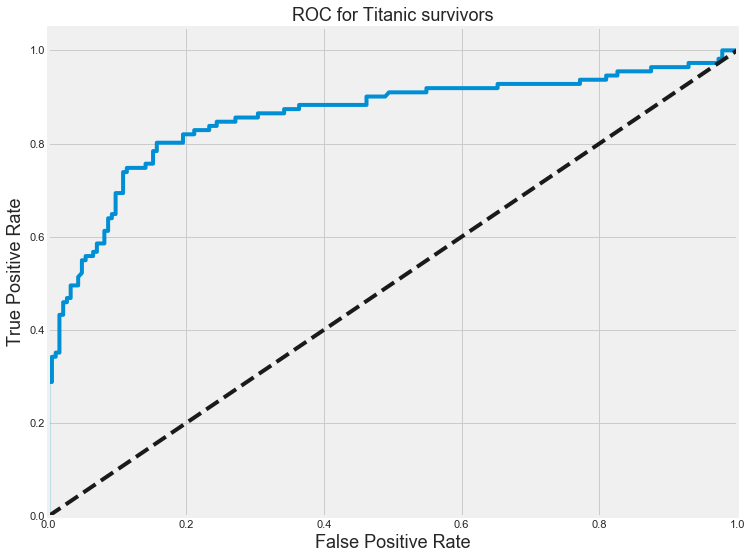

In [93]:
y_score = logreg.decision_function(X_test) # gets confidence score for the function
FPR, TPR, _ = roc_curve(y_test, y_score)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Titanic survivors', fontsize= 18)
plt.show()

#### Using cross validation

In [94]:
cv = StratifiedShuffleSplit(n_splits = 10, test_size=.25, random_state = 0)

In [95]:
column_names = X.columns
X = std_scale.fit_transform(X) #standard scalar
# accuracies = cross_val_score(LogisticRegression(solver='liblinear'), X,y,cv=)

In [96]:
accuracies = cross_val_score(LogisticRegression(solver='liblinear'), X,y, cv= cv)

In [97]:
print("Cross-Validation accuracy score: {}".format(accuracies))

print("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),5)))

Cross-Validation accuracy score: [0.80269058 0.8161435  0.82511211 0.86098655 0.8161435  0.8161435
 0.8206278  0.86995516 0.80717489 0.82511211]
Mean Cross-Validation accuracy score: 0.82601


In [98]:
# GridSearchCV

In [99]:
# C_vals is the aplha value of lasso and ridge regression (hyperparameter)

In [100]:
C_vals = [0.2,0.3,0.4,.5,.6,.7,.8,.9,1]
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25)
param = {'C':C_vals}

In [101]:
logreg = LogisticRegression()
grid = GridSearchCV(estimator= logreg, param_grid= param, scoring='accuracy',n_jobs=-1, cv = cv)

In [102]:
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [103]:
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.8228699551569507
{'C': 0.2}
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [104]:
logreg_grid = grid.best_estimator_
logreg_grid.score(X,y)

0.8417508417508418

## K-Nearest Neighbor Classifier (KNN)

In [105]:
knn = KNeighborsClassifier(metric = 'minkowski', p=2)
cv = StratifiedShuffleSplit(n_splits=10, test_size=.25, random_state=0)
accuracies = cross_val_score(knn, X,y,cv=cv, scoring='accuracy')
accuracies

array([0.79820628, 0.73991031, 0.77130045, 0.81165919, 0.77130045,
       0.74439462, 0.77578475, 0.80269058, 0.76681614, 0.76233184])

In [106]:
print('Mean Cross Validation Accuracy Score: {}'.format(round(accuracies.mean(),4)))

Mean Cross Validation Accuracy Score: 0.7744


In [107]:
# find the best k-value for KNN

In [108]:
k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
    
    k_scores.append(scores.mean())
    

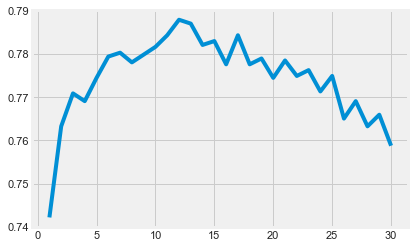

In [109]:
plt.plot(k_range, k_scores)

#### Grid search on KNN classifier

In [110]:
k_range = range(1,31)
weights_options = ['uniform', 'distance']

param = {'n_neighbors':k_range, 'weights':weights_options}
cv = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=0)


In [111]:
grid = GridSearchCV(KNeighborsClassifier(), param, cv=cv, verbose=False, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=False)

In [112]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7847014925373135
{'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')


In [113]:
knn_grid = grid.best_estimator_
knn_grid.score(X,y)

0.8361391694725028

#### Using RandomizedSearchCV

In [114]:
# Randomized SearchCV: close cousin of grid search

In [115]:
k_range = range(1,31)
weights_options = ['uniform', 'distance']
param = {'n_neighbors':k_range, 'weights':weights_options}

cv = StratifiedShuffleSplit(n_splits=10, test_size=.3)
grid = RandomizedSearchCV(KNeighborsClassifier(), param, cv=cv, verbose=False, n_jobs=-1)
grid.fit(X,y)


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.3,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'n_neighbors': range(1, 31),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=False)

In [116]:
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.7817164179104478
{'weights': 'uniform', 'n_neighbors': 21}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')


In [117]:
knn_ran_grid = grid.best_estimator_
knn_ran_grid.score(X,y)

0.8159371492704826

### Gaussian Naive Bayes

In [118]:
gaussian = GaussianNB()
gaussian.fit(X,y)
y_pred = gaussian.predict(X_test)
gaussian_accy = round(accuracy_score(y_pred, y_test),3)
print(gaussian_accy)

0.793


### SVM

In [119]:
from sklearn.svm import SVC

In [120]:
#penalty parameter C for the error term
Cs = [.001, .01, .1, 1, 1.5, 2, 2.5, 3, 4, 5,10]
gammas = [.0001, .001, .01, 1] #parameter for nonlinear hyperplanes. The higher the gammma value, it tries to exactly fit the training data set
param_grid = {'C':Cs, 'gamma':gammas}
cv = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=15)
grid_search = GridSearchCV(SVC(kernel='rbf', probability=True),param_grid, cv=cv)#rbf: gaussian kernel
grid_search.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5, 3, 4, 5, 10],
                         'gamma': [0.0001, 0.001, 0.01, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [121]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8324626865671642
{'C': 1.5, 'gamma': 0.01}
SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [122]:
svm_grid = grid_search.best_estimator_
svm_grid.score(X,y)

0.8484848484848485

### Decision Tree Classifier

In [123]:
from sklearn.tree import DecisionTreeClassifier

In [124]:
max_depth = range(1,30)
max_feature = [21,22,23,24,25,26,28,29,30, 'auto']
criterion = ['entropy', 'gini']
cv = StratifiedShuffleSplit(n_splits=20, random_state=15)


param = {'max_depth':max_depth,'max_features':max_feature,'criterion':criterion}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param, verbose=False, cv=cv, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=20, random_state=15, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'cri

In [125]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 24}
0.8322222222222222
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=24, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [126]:
dectree_grid = grid.best_estimator_
dectree_grid.score(X,y)

0.8585858585858586

In [127]:
feature_importances = pd.DataFrame(dectree_grid.feature_importances_, index=column_names, columns=['importance'])

In [128]:
feature_importances.sort_values(by='importance',ascending=False).head(10)

,importance
Title_Mr,0.530066
Pclass_3,0.149966
calculated_fare,0.117675
SibSp,0.055855
Title_Other,0.033789
Sex,0.032445
Cabin_D,0.021456
Age,0.021363
name_length_group_good,0.012671
Embarked_Q,0.011999


#### Random Forest Classifier

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
n_estimators = [140,145,150,155,160]
max_depth = range(1,10)
criterions = ['gini', 'entropy']
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=0)

In [131]:
parameters = {'n_estimators':n_estimators, 'max_depth':max_depth, 'criterion':criterions}
grid = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'), param_grid=parameters, cv=cv,n_jobs=-1)

In [132]:
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              rand

In [133]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8283582089552238
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 160}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [134]:
rf_grid = grid.best_estimator_
rf_grid.score(X,y)

0.9057239057239057

In [135]:
from sklearn.metrics import classification_report

In [136]:
print(classification_report(y_test, y_pred, labels=rf_grid.classes_))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       184
           1       0.74      0.70      0.72       111

    accuracy                           0.79       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



In [137]:
feature_importances = pd.DataFrame(rf_grid.feature_importances_, index=column_names, columns=['importance'])
feature_importances.sort_values(by='importance',ascending=False).head(10)

,importance
Title_Mr,0.171547
Sex,0.111893
calculated_fare,0.109584
Age,0.082780
Title_Miss,0.056115
Pclass_3,0.043456
Title_Mrs,0.041342
SibSp,0.038168
Pclass_1,0.029657
Cabin_G,0.022356


### Bagging Classifier

In [138]:
from sklearn.ensemble import BaggingClassifier

In [139]:
n_estimators = [10,30,50,60,80,150,160,170,175,180,185]
cv=StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state = 0)
parameters = {'n_estimators':n_estimators}

In [140]:
grid = GridSearchCV(BaggingClassifier(base_estimator=None,bootstrap_features=False), param_grid=parameters,cv=cv,n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
             error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 60, 80, 150, 160, 170,
                                          175, 180, 185]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [141]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8167910447761194
{'n_estimators': 170}
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=170,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)


In [142]:
bagging_grid = grid.best_estimator_
bagging_grid.score(X,y)

0.9887766554433222

### AdaBoost

In [143]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,140,145, 150, 160,170,175,180,185]
learning_r = [.1,1,.01, .5]
cv = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=0)


parameters = {'n_estimators':n_estimators, 'learning_rate':learning_r}

In [144]:
#base_estimator = Normal Decision Tree
grid = GridSearchCV(AdaBoostClassifier(base_estimator=None), param_grid=parameters,cv=cv, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
             error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1, 0.01, 0.5],
                         'n_estimators': [100, 140, 145, 150, 160, 170, 175,
                                          180, 185]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [145]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.816044776119403
{'learning_rate': 0.1, 'n_estimators': 145}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=145, random_state=None)


In [146]:
adaBoost_grid = grid.best_estimator_
adaBoost_grid.score(X,y)

0.8282828282828283

### Gradient Boosting Classifer

In [147]:
from sklearn.ensemble import GradientBoostingClassifier

In [148]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [149]:
y_pred = gradient_boost.predict(X_test)

In [150]:
round(accuracy_score(y_pred,y_test),3)

0.895

### XGBClassifier

In [151]:
from xgboost import XGBClassifier

In [152]:
XGBClassifier = XGBClassifier()
XGBClassifier.fit(X,y)
y_pred = XGBClassifier.predict(X_test)
round(accuracy_score(y_pred, y_test),3)

0.878

### Extra Trees Classifier

In [153]:
from sklearn.ensemble import ExtraTreesClassifier

In [154]:
ExtraTreesClassifier = ExtraTreesClassifier()
ExtraTreesClassifier.fit(X,y)
y_pred = ExtraTreesClassifier.predict(X_test)

In [155]:
round(accuracy_score(y_pred, y_test),3)

0.949

### Gaussian Process Classifier

In [156]:
from sklearn.gaussian_process import GaussianProcessClassifier
GaussianProcessClassifier = GaussianProcessClassifier()
GaussianProcessClassifier.fit(X,y)

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

In [157]:
y_pred = GaussianProcessClassifier.predict(X_test)
accuracy_score(y_pred, y_test)

0.9423728813559322

### Voting Classifier

In [158]:
from sklearn.ensemble import VotingClassifier

In [159]:
voting_classifier = VotingClassifier(estimators = [
    ('lr_grid', logreg_grid),
    ('svc', svm_grid),
    ('random_forest', rf_grid),
    ('gradient_boosting', gradient_boost),
    ('decision_tree_grid',dectree_grid),
    ('knn_classifier', knn_grid),
    ('XGB_Classifier', XGBClassifier),
    ('bagging_classifier', bagging_grid),
    ('adaBoost_classifier',adaBoost_grid),
    ('ExtraTrees_Classifier', ExtraTreesClassifier),
    ('gaussian_classifier',gaussian),
    ('gaussian_process_classifier', GaussianProcessClassifier)
],voting='hard')

In [160]:
voting_classifier = voting_classifier.fit(X,y)

In [161]:
y_pred = voting_classifier.predict(X_test)

In [162]:
voting_accy = round(accuracy_score(y_pred, y_test),3)
voting_accy

0.892

### Submit test predictions

In [163]:
all_models = [
    logreg_grid,
    knn_grid,
    knn_ran_grid,
    svm_grid,
    dectree_grid,
    rf_grid,
    bagging_grid,
    adaBoost_grid,
    voting_classifier
]

In [164]:
c = {}

In [165]:
for i in all_models:
    a = i.predict(X_test)
    b = accuracy_score(a, y_test)
    c[i] = b

In [166]:
(max(c, key=c.get))

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=170,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [167]:
test_prediction = (max(c, key=c.get)).predict(test)

In [170]:
test = pd.read_csv('test.csv')

In [172]:
passengerid = test.PassengerId

In [173]:
submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": test_prediction
    })

In [174]:
submission.PassengerId = submission.PassengerId.astype(int)
submission.Survived = submission.Survived.astype(int)

In [175]:
submission.to_csv("titanic_submission.csv", index=False)

## Refrences:

https://www.kaggle.com/faressayah/data-science-best-practices-using-pandas-titanic

https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic